In [37]:
import pandas as pd
import mysql.connector
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt             
%matplotlib inline     
sns.set(color_codes=True)

import os
import scipy as sp
import warnings
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline


# Menghubungkan ke database MySQL
db_connection = mysql.connector.connect(
    host="localhost",  # Ganti dengan host database Anda
    user="root",   # Ganti dengan username database Anda
    password="",  # Ganti dengan password database Anda
    database="jurujual_pos"  # Ganti dengan nama database Anda
)

# Memuat data dari tabel
query = """
SELECT s.date AS Tanggal, s.reference AS Reference, s.customer_name AS Pembeli, 
    p.product_unit AS Satuan, p.product_name AS Produk, c.category_name AS Kategori,
    sd.quantity AS Qty, p.product_price AS HargaJual, sd.product_discount_amount AS Diskon,
    sp.amount AS SubTotal, s.payment_method AS MetodePembayaran, 
    s.status AS Status, s.payment_status AS StatusPembayaran
    
FROM sales s
JOIN sale_details sd ON s.id = sd.sale_id
JOIN sale_payments sp ON s.id = sp.sale_id
JOIN products p ON sd.product_id = p.id
JOIN categories c ON p.category_id = c.id;
"""

df = pd.read_sql(query, con=db_connection)
db_connection.close()

In [38]:
df['Tanggal'] = pd.to_datetime(df.Tanggal)
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year
# drop Tanggal
df.drop(columns = ["Tanggal"], inplace = True)

In [39]:
list_1 = list(df.columns)
list_cate = []
for i in list_1:
    if df[i].dtype == 'object':
        list_cate.append(i)
le = LabelEncoder()
for i in list_cate:
    df[i] = le.fit_transform(df[i])

In [40]:
y = df['Qty']
X = df[['Reference', 'Pembeli', 'Satuan', 'Produk', 'Kategori', 'SubTotal', 'HargaJual', 'Diskon', 'MetodePembayaran', 'Status', 'StatusPembayaran', 'Bulan', 'Tahun']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Analisis Korelasi

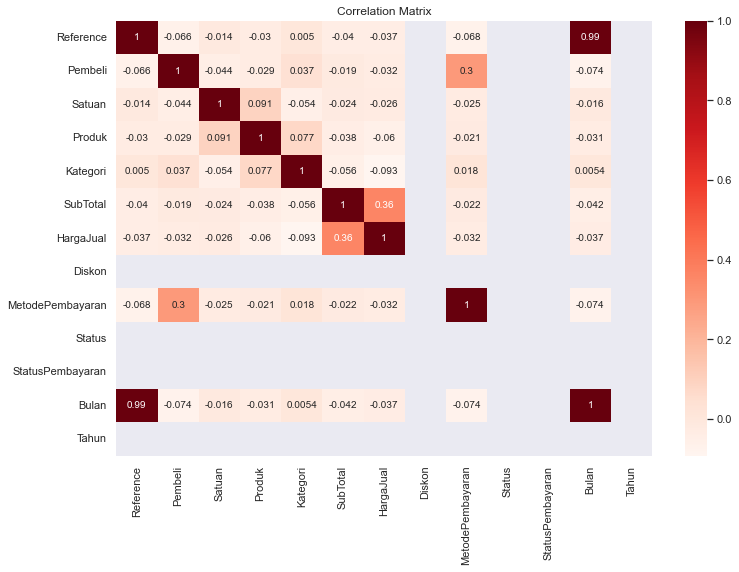

In [41]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap=plt.cm.Reds)
plt.title("Correlation Matrix")
plt.show()

### Variance Inflation Factor (VIF)

In [42]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF for each feature:\n", vif_data)

VIF for each feature:
              feature        VIF
0          Reference  76.954303
1            Pembeli   1.106042
2             Satuan   1.015577
3             Produk   1.020563
4           Kategori   1.019827
5           SubTotal   1.155453
6          HargaJual   1.164113
7             Diskon        NaN
8   MetodePembayaran   1.101138
9             Status        NaN
10  StatusPembayaran        NaN
11             Bulan  77.097076
12             Tahun  23.588640


### Feature Importance from Random Forest

In [43]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print("Feature importances:\n", feature_importances)

Feature importances:
                   importance
SubTotal            0.541813
HargaJual           0.295661
Produk              0.060315
Kategori            0.031611
Reference           0.019398
Pembeli             0.017945
Bulan               0.017211
Satuan              0.012727
MetodePembayaran    0.003319
Diskon              0.000000
Status              0.000000
StatusPembayaran    0.000000
Tahun               0.000000


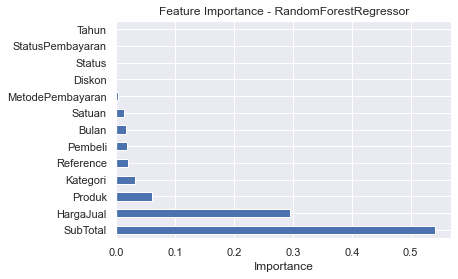

In [44]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(13).plot(kind='barh')
plt.title('Feature Importance - RandomForestRegressor')
plt.xlabel('Importance')
plt.show()

### Recursive Feature Elimination (RFE)

In [45]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X, y)
print("RFE selected features:\n", fit.support_)
print("RFE feature ranking:\n", fit.ranking_)

RFE selected features:
 [False  True  True False  True False False False  True False False  True
 False]
RFE feature ranking:
 [3 1 1 2 1 5 4 6 1 9 8 1 7]


### Lasso Regression

Lasso coefficients:
 Reference          -0.000000e+00
Pembeli             0.000000e+00
Satuan              0.000000e+00
Produk             -0.000000e+00
Kategori           -0.000000e+00
SubTotal            3.060300e-07
HargaJual          -4.009767e-07
Diskon              0.000000e+00
MetodePembayaran   -0.000000e+00
Status              0.000000e+00
StatusPembayaran    0.000000e+00
Bulan              -0.000000e+00
Tahun               0.000000e+00
dtype: float64


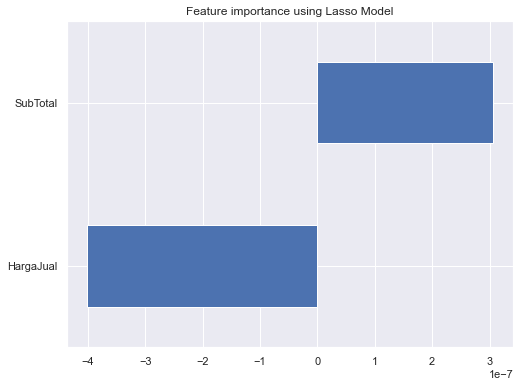

In [46]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", coef)
imp_coef = coef[coef != 0].sort_values()
plt.figure(figsize=(8, 6))
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")
plt.show()

### Univariate Feature Selection

In [47]:
from sklearn.feature_selection import SelectKBest, f_regression

# Initialize SelectKBest
skb = SelectKBest(score_func=f_regression, k=9)

# Fit SelectKBest
skb.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[skb.get_support()]
print(selected_features)


Index(['Reference', 'Pembeli', 'Satuan', 'Produk', 'Kategori', 'SubTotal',
       'HargaJual', 'MetodePembayaran', 'Bulan'],
      dtype='object')
